In [1]:
import sys
sys.path.append('/home/dominhnhat/Classroom/deepul')
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')
ptu.set_gpu_mode(True)

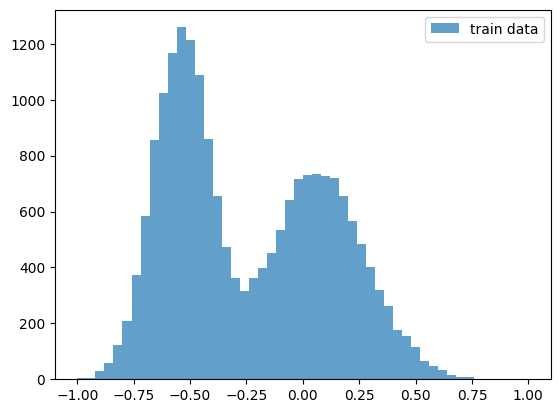

In [2]:
visualize_q1_dataset()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

In [53]:
device = 'cuda'

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super().__init__()
        layers = []

        prev = input_size
        for i in hidden_layers:
            layers.append(nn.Linear(prev, i))
            layers.append(nn.LeakyReLU(0.2))
            prev = i
        
        layers.append(nn.Linear(prev, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #print(x.dtype)
        #print('lmao')
        return self.layers(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_layers, output_size):
        super().__init__()
        self.latent_dim = latent_dim
        self.net = MLP(latent_dim, hidden_layers, output_size)
        
    def forward(self, x):
        return torch.tanh(self.net(x)) #lol our distribution is in range [-1, 1]

    def sample(self, n):
        z = torch.randn(n, self.latent_dim).to(device)
        samples = self.forward(z)
        return samples

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super().__init__()
        self.net = MLP(input_size, hidden_layers, output_size)
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))

def generator_loss(gen : Generator, dis : Discriminator, x):
    fake_data = gen.sample(x.shape[0])
    return (1 - dis(fake_data)).log().mean()

def discriminator_loss(gen : Generator, dis : Discriminator, x):
    fake_data = gen.sample(x.shape[0])
    return - (1 - dis(fake_data)).log().mean() - dis(x).log().mean()

G = Generator(latent_dim = 1, hidden_layers = [128, 128, 128], output_size = 1).to(device)
D = Discriminator(input_size = 1,hidden_layers = [128, 128, 128], output_size = 1).to(device)

G_optimizer = optim.Adam(G.parameters(), lr=1e-3)
D_optimizer = optim.Adam(D.parameters(), lr=1e-3)

def train_epoch(G, D, generator_iter, dataloader, debug = True):

    epoch_d_loss = []

    for i, X in enumerate(dataloader):
        X = X.to(device).to(torch.float32)

        #print(X.dtype)

        d_loss = discriminator_loss(G, D, X)
        D_optimizer.zero_grad()
        d_loss.backward()
        D_optimizer.step()

        if (i % generator_iter == 0):
            g_loss = generator_loss(G, D, X)
            G_optimizer.zero_grad()
            g_loss.backward()
            G_optimizer.step()

            if (debug == True and i % 50 == 0):
                print(f'Batch number {i} || D loss : {d_loss} || G loss : {g_loss}')
        
        epoch_d_loss.append(d_loss.detach().cpu().numpy())
    
    return epoch_d_loss

def train(G, D, dataloader, epochs, debug = True):
    training_loss = []   
    for epoch in range(0, epochs):
        if (debug == True):
            print(f'epoch number {epoch} : ' + '-'*30)

        epoch_d_loss = train_epoch(G, D, 5, dataloader, debug)
        for i in epoch_d_loss:
            training_loss.append(i)
    
    return np.array(training_loss)

epoch number 0 : ------------------------------
Batch number 0 || D loss : 1.387761116027832 || G loss : -0.6775048971176147
Batch number 50 || D loss : 0.9238244295120239 || G loss : -0.5356742143630981
Batch number 100 || D loss : 1.1815173625946045 || G loss : -0.6718285083770752
Batch number 150 || D loss : 1.2693942785263062 || G loss : -0.7009131908416748
Batch number 200 || D loss : 1.1634984016418457 || G loss : -0.5374391078948975
Batch number 250 || D loss : 1.3061444759368896 || G loss : -0.6633896231651306
Batch number 300 || D loss : 1.3223381042480469 || G loss : -0.6500846147537231
epoch number 1 : ------------------------------
Batch number 0 || D loss : 1.3869013786315918 || G loss : -0.7003408074378967
Batch number 50 || D loss : 1.2909224033355713 || G loss : -0.6425318121910095
Batch number 100 || D loss : 1.4230213165283203 || G loss : -0.7749743461608887
Batch number 150 || D loss : 1.3933234214782715 || G loss : -0.7455446124076843
Batch number 200 || D loss : 1.

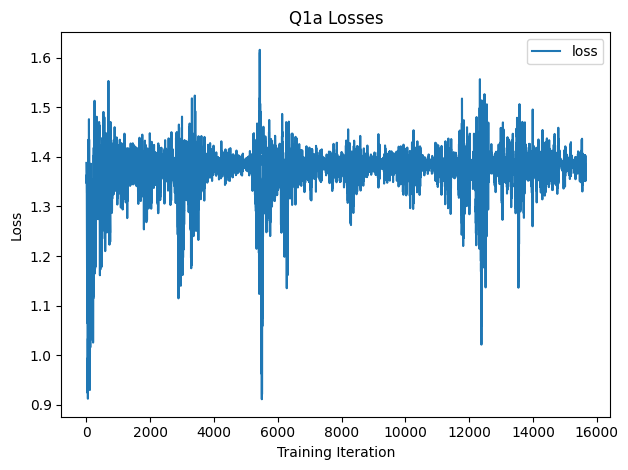

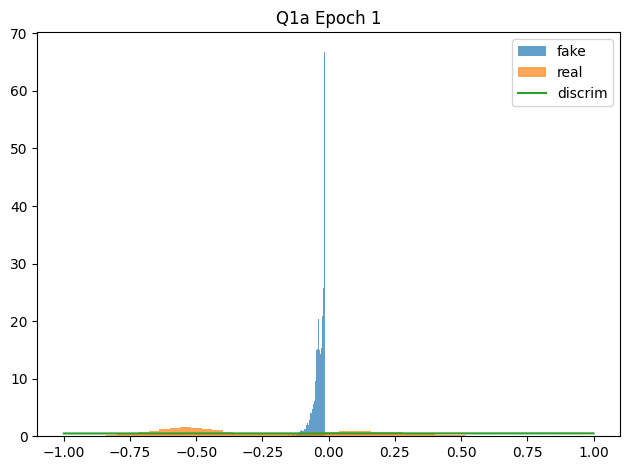

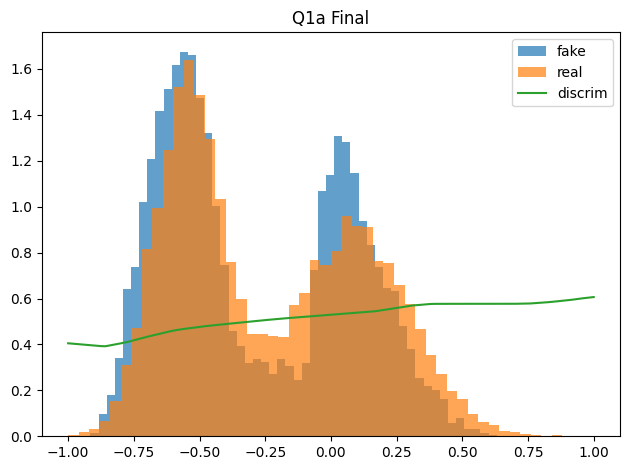

In [54]:
def convert_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    init_sample = G.sample(5000)
    xs1 = np.linspace(-1, 1, 1000)

    fit_xs1 = torch.FloatTensor(xs1.reshape(1000, 1)).to(device)
    init_D_output = D(fit_xs1)

    training_loss = train(G, D, train_loader, 50)

    end_sample = G.sample(5000)
    xs2 = np.linspace(-1, 1, 1000)

    fit_xs2 = torch.FloatTensor(xs2.reshape(1000, 1)).to(device)
    end_D_output = D(fit_xs2)

    

    return training_loss, convert_to_numpy(init_sample), xs1, convert_to_numpy(init_D_output), convert_to_numpy(end_sample), xs2, convert_to_numpy(end_D_output)

q1_save_results('a', q1_a)